<a href="https://colab.research.google.com/github/vladtsyp/study_deeplearning/blob/main/s/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Тема:** Предсказание продолжительности поездки такси с помощью методов машинного обучения на основе геопространственных данных

**Подготовили студенты ФГиИБ ПИабпд 1м**:
*   Цыпленков Владислав Ильич
*   Корякин Владислав Алексеевич
*   Пивоваров Тимофей Алексеевич
*   Аль-Савади Карим Аммарович
*   Керницкий Олег Витальевич


Датасет: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data

Описание файлов

    train.csv - набор данных для обучения (содержит 1458644 записей)
    test.csv - набор данных для теста (содержит 625134 записей)
    sample_submission.csv - образец файла для отправки в правильном формате

Поля данных

    id - уникальный идентификатор для каждой поездки
    vendor_id - код, указывающий поставщика, связанного с записью поездки
    pickup_datetime - дата и время включения счетчика
    dropoff_datetime - дата и время отключения счетчика
    passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
    pickup_longitude - долгота, на которой был включен счетчик
    pickup_latitude - широта, на которой был включен измеритель
    dropoff_longitude - долгота, на которой счетчик был отключен
    dropoff_latitude - широта, на которой счетчик был отключен
    store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в
          памяти транспортного средства перед отправкой поставщику.
              Y - хранить и пересылать, N - не хранить и не пересылать поездку.
    trip_duration - продолжительность поездки в секундах


# Загрузка данных и обзор

In [ ]:
# импортируем зависимости
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [ ]:
# распаковываем архив с данными
!unzip -q '/content/drive/MyDrive/Colab Notebooks/zharov/nyc-taxi-trip-duration.zip' -d '/content/nttd'

In [ ]:
# читаем csv-файлы и создаём объекты DataFrame
train_df = pd.read_csv('/content/nttd/train.zip', compression='zip')
test_df = pd.read_csv('/content/nttd/test.zip', compression='zip')

In [ ]:
# отображаем первые 5 записей
train_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
test_df.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [ ]:
# вывод информации о структуре датафреймов
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  


# Очистка данных

Очистка данных означает избавление от неактуальных данных во всей модели. Этот процесс устраняет неточность результатов путем удаления ненужных данных. Он также гарантирует, что данные являются последовательными, корректными и пригодными для использования. Процесс очистки данных можно начать с выявления ошибок и решения проблем путем удаления данных.
Очистка данных — это ещё и важный этап машинного обучения. Если модель обучить на неочищенных данных, она просто не будет нормально работать и станет выдавать совершенно неадекватные результаты.

## Повторяющиеся и отсутствующие значения

In [ ]:
# Количество дублированных строк
train_df.duplicated().sum()

0

In [ ]:
# Количество NaN значений для каждого столбца
train_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Cтатистические характеристики

In [ ]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Отчётливо видно, что `trip_duration` принимает странные значения для min и max. Проведём быструю визуализацию с помощью boxplot.
Также видно, что минимальное значение `passenger_count` равно нулю.

**Выбросы** *(англ. outliers)* – объекты, значения признаков которых сильно отличаются от признаков основной массы объектов. То есть это объекты, сильно выпадающие из общей картины.

Откуда же берутся выбросы? Во-первых, появление выбросов может быть обусловлено технической стороной эксперимента (например, в процессе сбора данных сменилось оборудование или у прежнего изменилась чувствительность датчиков). Во-вторых, на появление выбросов может влиять человеческий фактор. Возможны и другие причины: изменение правил проведения эксперимента, какая-то случайность или действительно уникальное значение.

В любом случае, какой бы ни была причина появления выбросов, они мешают алгоритмам обучаться, т.е. не дают построить хорошее решающее правило. Конечно, существуют алгоритмы машинного обучения (робастные), которые сами удачно обрабатывают выбросы. Но большинство алгоритмов путается в выбросах, пытается предсказать соответствующее значение для них, а в итоге плохо предсказывает значения как для выбросов, так и для остальных значений. Поэтому для получения хорошего решающего правила для основной массы объектов рекомендуется выявлять аномалии и обрабатывать их.

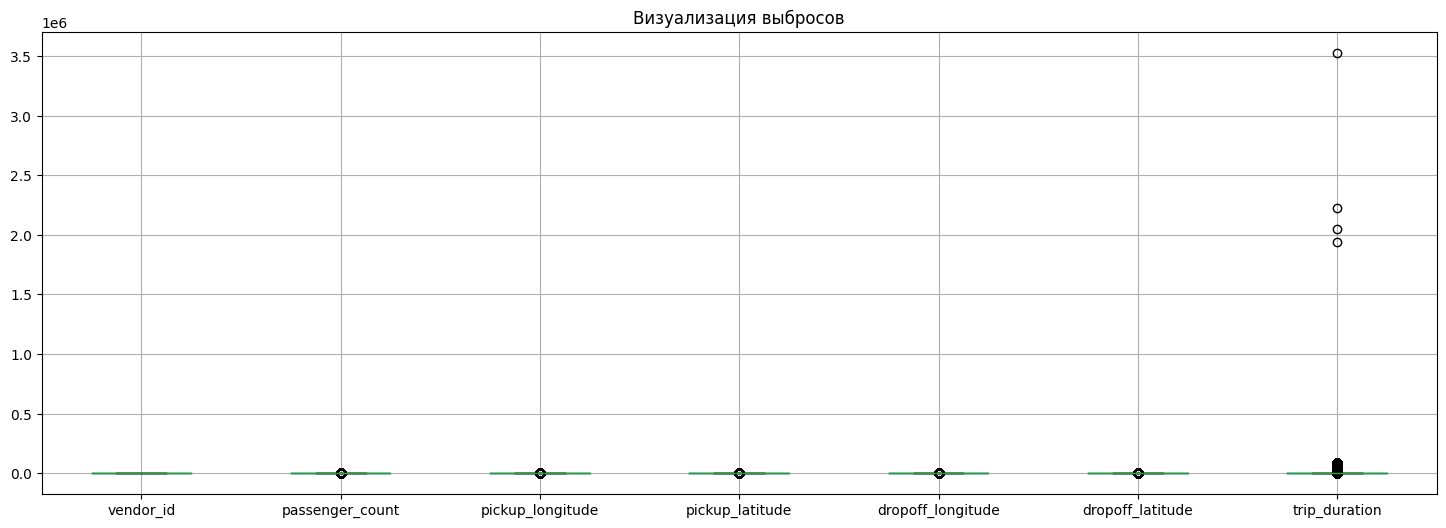

In [ ]:
# Визуализация выбросов

plt.subplots(figsize=(18,6))
plt.title("Визуализация выбросов")
train_df.boxplot();

В `trip_duration` есть выбросы, поэтому от них необходимо избавиться.
Оставляем поездки не более 7200 секунд (2 часа) и где был хотя бы один пассажир

In [ ]:
train_df = train_df[(train_df.trip_duration < 7200)]
train_df = train_df[(train_df.passenger_count > 0)]

train_df.shape # размерность данных

(1456332, 11)

Визуализация выбросов по координатам начала и конца поездки

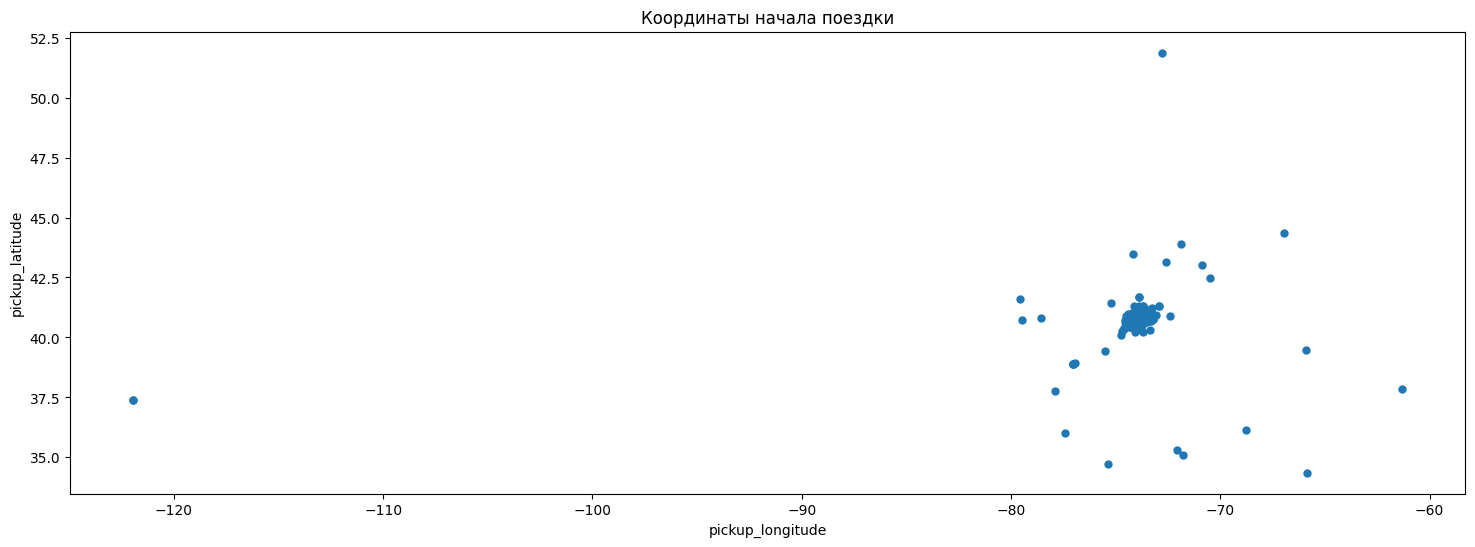

In [ ]:
pickup_longitude = list(train_df.pickup_longitude)
pickup_latitude = list(train_df.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('Координаты начала поездки')
plt.show()

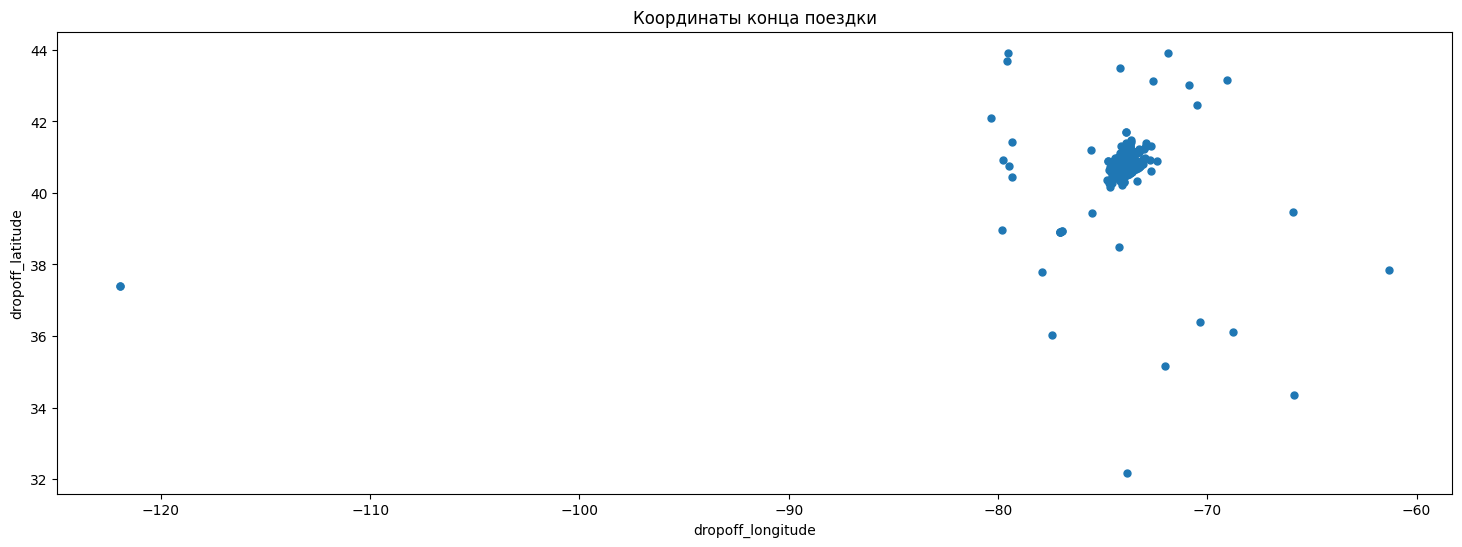

In [ ]:
dropoff_longitude = list(train_df.dropoff_longitude)
dropoff_latitude = list(train_df.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.title('Координаты конца поездки')
plt.show()

In [ ]:
train_df[train_df['dropoff_longitude'] < -100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.933235,37.389297,-121.933205,37.389103,N,1105
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.933342,37.389381,-121.933304,37.389511,N,499


In [ ]:
# Удаление выбросов по координатым
train_df = train_df[(train_df.pickup_longitude > -100)]
train_df = train_df[(train_df.pickup_latitude < 50)]
train_df.shape

(1456329, 11)

**Вывод:** в ходе выполнения данного этапа мы проверили и очистили (ограничили) наши данные от выбросов и некорректных значений.

# Построение признаков (Feature Engineering)

**Признак**, он же «фича» *(от англ feature)* – это переменная (столбец в таблице), которая описывает отдельную характеристику объекта. Признаки являются краеугольным камнем задач машинного обучения в целом: именно на их основании мы строим предсказания в моделях.
Признаки могут быть следующих видов:
*   ***Бинарные***, которые принимают только два значения. Например, [true, false], [0,1], [“да”, “нет”].
*   ***Категориальные*** (или же номинальные). Они имеют конечное количество уровней, например, признак «день недели» имеет 7 уровней: понедельник, вторник и т. д. до воскресенья.
*   ***Упорядоченные***. В некоторой степени похожи на категориальные признаки. Разница между ними в том, что данном случае существует четкое упорядочивание категорий. Например, «классы в школе» от 1 до 11. Сюда же можно отнести «время суток», которое имеет 24 уровня и является упорядоченным.
*   ***Числовые*** (количественные). Это значения в диапазоне от минус бесконечности до плюс бесконечности, которые нельзя отнести к предыдущим трем типам признаков.
Стоит отметить, что для задач машинного обучения нужны только те «фичи», которые на самом деле влияют на итоговый результат.

**Построение признаков** *(Feature Engineering)* – это процесс, во время которого мы извлекаем новые переменные для таблицы из необработанных данных. В жизни редко данные приходят в виде готовых матриц, потому любая задача начинается с извлечения признаков.

## Работа с целью ('target')

Наша целевая переменная (признак) - длительность поездки
Визуализацируем распределение значений `trip_duration`

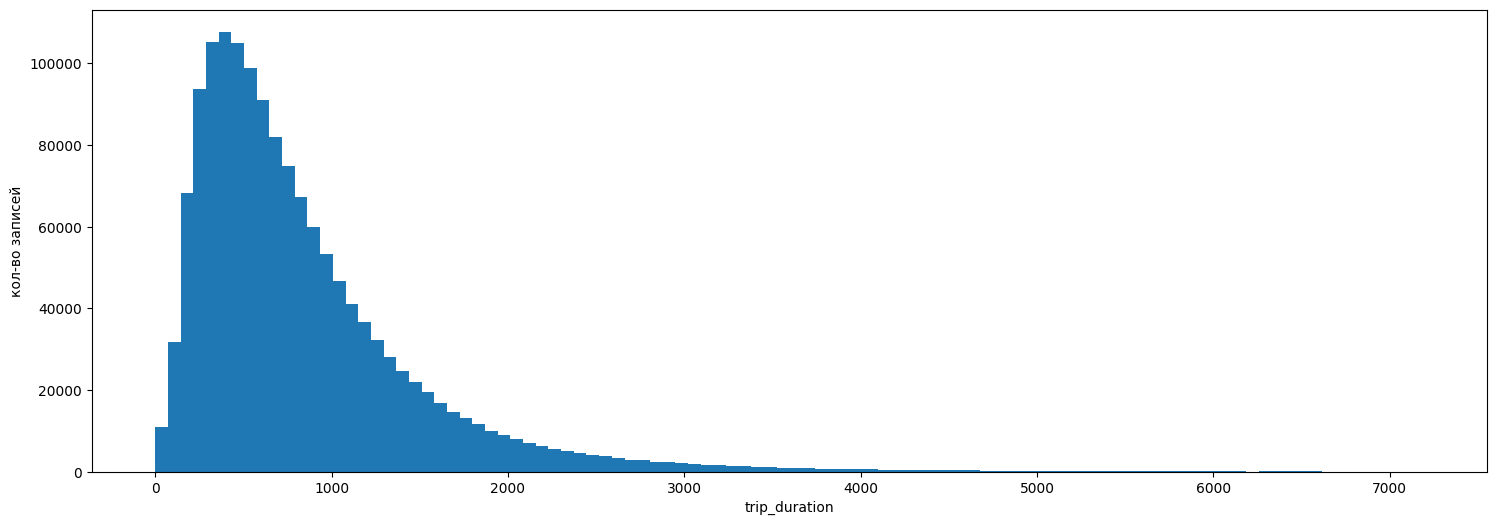

In [ ]:
plt.subplots(figsize=(18,6))
plt.hist(train_df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('кол-во записей')
plt.show()

По графику видно, что значения `trip_duration` образуют скошенное вправо (right-skewed, хвост графика вправо) распределение.
В таких случаях применяют логарифмическое преобразование.
Ценность логарифмического преобразования в том, что:

*   расстояние между небольшими значениями увеличивается
*   расстояние между большими значениями наоборот уменьшается

И, таким образом, это преобразование делает скошенное распределение более симметричным и приближенным к нормальному.

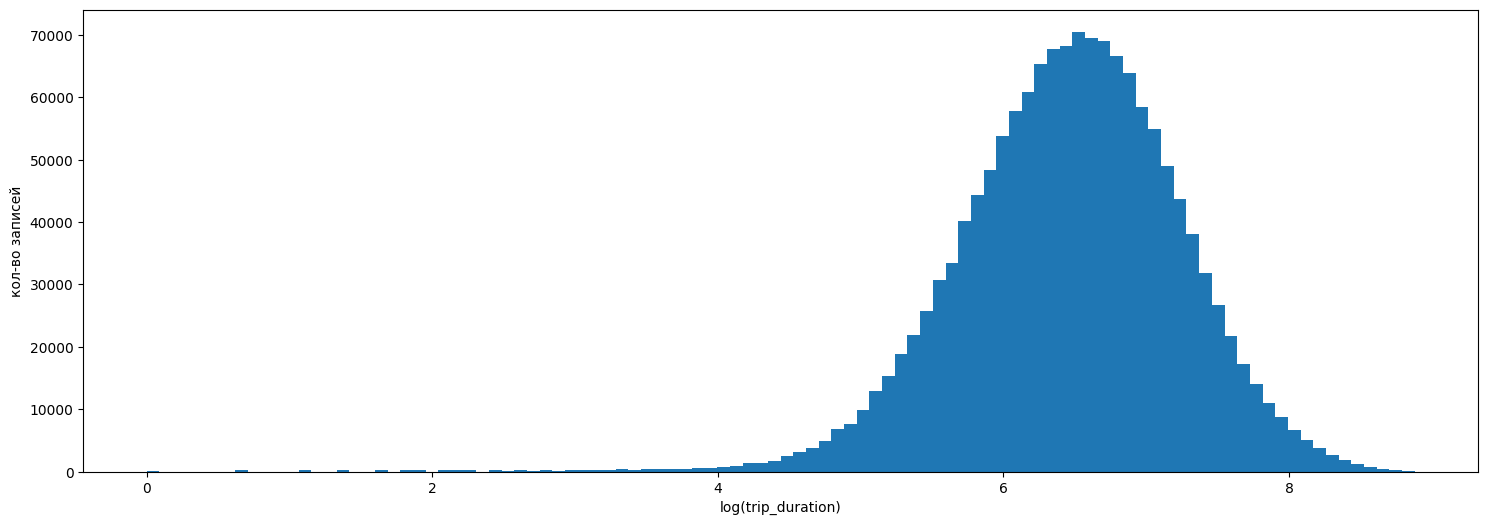

In [ ]:
plt.subplots(figsize=(18,6))
train_df['trip_duration'] = np.log(train_df['trip_duration'].values)
plt.hist(train_df['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('кол-во записей')
plt.show()

## Категориальные признаки

**Быстрое кодирование (one-hot encoding) бинарных категориальных признаков**
Этот метод распределяет значения в столбце по нескольким столбцам флагов и присваивает им 0 или 1. Бинарные значения выражают связь между сгруппированным и закодированным столбцом. Этот метод изменяет категориальные данные, которые сложно понять алгоритмам, в числовой формат. Группировка происходит без потери какой-либо информации.
Компьютер работает с числами, поэтому строковые категориальные и бинарные значения следует перевести в числовые. В нашем случае это значения `store_and_fwd_flag` и `vendor_id`
В Python-библиотеке Pandas имеется функция pd.get_dummies(), которая конвертирует категориальные значения в числовые. Воспользуемся ей.

In [ ]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['store_and_fwd_flag'])], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['vendor_id'])], axis=1)
train_df.drop(['store_and_fwd_flag'], axis=1, inplace=True)
train_df.drop(['vendor_id'], axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df['store_and_fwd_flag'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['vendor_id'])], axis=1)

## Работа со времененными признаками

In [ ]:
# Преобразование даты
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)

# поскольку у нас нет этого признака в тестовом наборе
train_df.drop(['dropoff_datetime'], axis=1, inplace=True)

# Разделение общей даты на отдельные вр-ые признаки
train_df['month'] = train_df.pickup_datetime.dt.month
train_df['week'] = train_df.pickup_datetime.dt.week
train_df['weekday'] = train_df.pickup_datetime.dt.weekday
train_df['hour'] = train_df.pickup_datetime.dt.hour
train_df['minute'] = train_df.pickup_datetime.dt.minute
train_df['minute_oftheday'] = train_df['hour'] * 60 + train_df['minute']
train_df.drop(['minute'], axis=1, inplace=True)

test_df['month'] = test_df.pickup_datetime.dt.month
test_df['week'] = test_df.pickup_datetime.dt.week
test_df['weekday'] = test_df.pickup_datetime.dt.weekday
test_df['hour'] = test_df.pickup_datetime.dt.hour
test_df['minute'] = test_df.pickup_datetime.dt.minute
test_df['minute_oftheday'] = test_df['hour'] * 60 + test_df['minute']
test_df.drop(['minute'], axis=1, inplace=True)

train_df.drop(['pickup_datetime'], axis=1, inplace=True)

train_df.info()

<ipython-input-11-c758f4ac9b33>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_df['week'] = train_df.pickup_datetime.dt.week
<ipython-input-11-c758f4ac9b33>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_df['week'] = test_df.pickup_datetime.dt.week


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456329 entries, 0 to 1458643
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1456329 non-null  object 
 1   passenger_count    1456329 non-null  int64  
 2   pickup_longitude   1456329 non-null  float64
 3   pickup_latitude    1456329 non-null  float64
 4   dropoff_longitude  1456329 non-null  float64
 5   dropoff_latitude   1456329 non-null  float64
 6   trip_duration      1456329 non-null  float64
 7   N                  1456329 non-null  uint8  
 8   Y                  1456329 non-null  uint8  
 9   1                  1456329 non-null  uint8  
 10  2                  1456329 non-null  uint8  
 11  month              1456329 non-null  int64  
 12  week               1456329 non-null  int64  
 13  weekday            1456329 non-null  int64  
 14  hour               1456329 non-null  int64  
 15  minute_oftheday    1456329 non-n

## Работа с пространственными данными

Функция для вычисления расстояния между двумя точек по координатам (Haversine formula)

In [ ]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # км
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

Добавляем столбец расстояния

In [ ]:
train_df['distance'] = haversine(train_df['pickup_latitude'].values,
                                train_df['pickup_longitude'].values,
                                train_df['dropoff_latitude'].values,
                                train_df['dropoff_longitude'].values)
test_df['distance'] = haversine(test_df['pickup_latitude'].values,
                                test_df['pickup_longitude'].values,
                                test_df['dropoff_latitude'].values,
                                test_df['dropoff_longitude'].values)

Функция для вычисления направления

In [ ]:
def degree(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 # км
    lng_delta_rad = np.radians(lng2 - lng1)
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

Добавляем столбец направления маршрута

In [ ]:
train_df['direction'] = degree(train_df['pickup_latitude'].values,
                                train_df['pickup_longitude'].values,
                                train_df['dropoff_latitude'].values,
                                train_df['dropoff_longitude'].values)
test_df['direction'] = degree(test_df['pickup_latitude'].values,
                              test_df['pickup_longitude'].values,
                              test_df['dropoff_latitude'].values,
                              test_df['dropoff_longitude'].values)

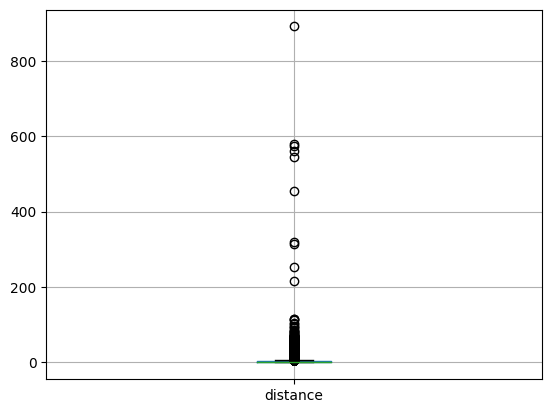

In [ ]:
# Визуализация выбросов по признаку расстояние
train_df.boxplot(column='distance', return_type='axes');

In [ ]:
# Удаление выбросов по расстоянию
train_df = train_df[(train_df.distance < 200)]

In [ ]:
# Создаём признак 'скорость'
train_df['speed'] = train_df.distance / train_df.trip_duration

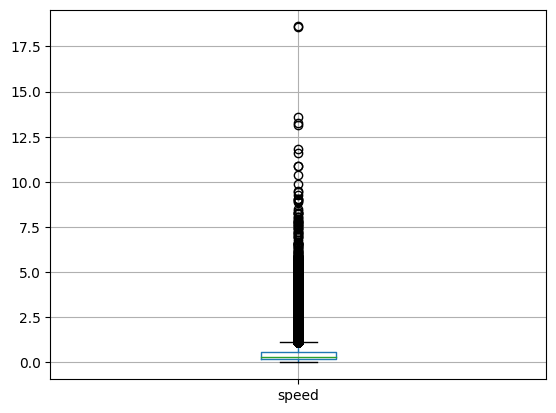

In [ ]:
# Визуализация выбросов по признаку скорость
train_df.boxplot(column='speed', return_type='axes');

In [ ]:
# Удаляем выбросы по признаку скорость
train_df = train_df[(train_df.speed < 15)]
train_df.drop(['speed'], axis=1, inplace=True)

<ipython-input-20-af81c5958e49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['speed'], axis=1, inplace=True)


## Карта корреляции переменных

https://www.delftstack.com/ru/howto/seaborn/correlation-heatplot-seaborn-python/
Корреляция - важнейший фактор, лежащий в основе анализа данных. Он сообщает, как переменные в наборе данных связаны друг с другом и как они перемещаются относительно друг друга. Значение корреляции колеблется от -1 до +1. Нулевая орреляция означает, что две переменные не зависят друг от друга. Положительная корреляция указывает на то, что переменные движутся в одном направлении, а отрицательная корреляция указывает на противоположное.

<ipython-input-21-b4abecca6b70>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=train_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Корреляция между переменными');


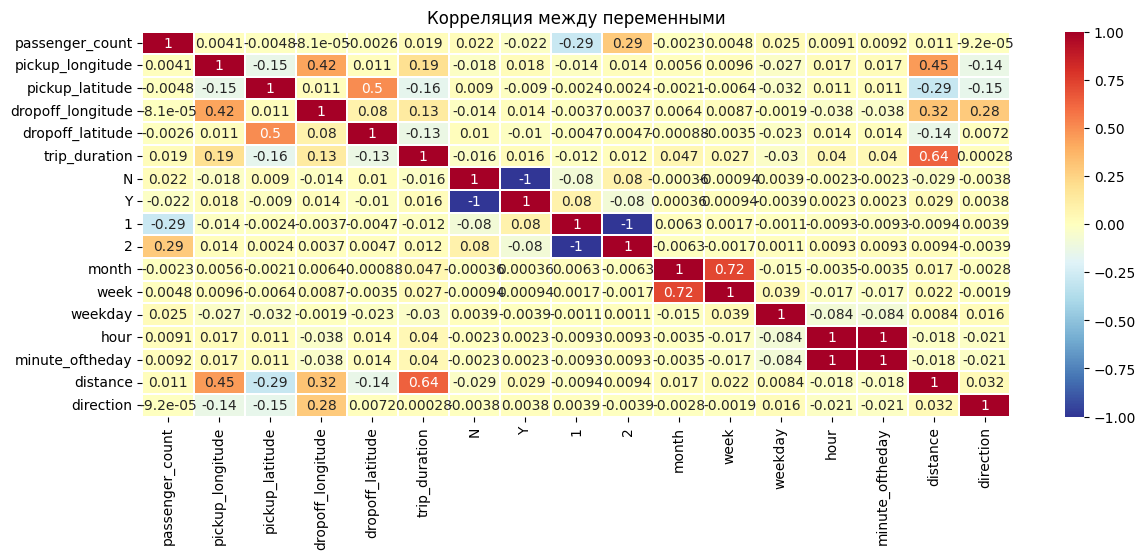

In [ ]:
fig, ax = plt.subplots(figsize=(14,5));
sns.heatmap(data=train_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Корреляция между переменными');

**Вывод:** в ходе выполнения данного этапа мы извлекли новые переменные для таблицы из необработанных данных, а также обработали их.

# Выбор модели

## Разделение выборки на обучающую и тестовую

In [ ]:
# Разделение на X и y (признаки и цель)
y = train_df["trip_duration"]
train_df.drop(["trip_duration"], axis=1, inplace=True)
train_df.drop(['id'], axis=1, inplace=True)
X = train_df

X.columns = X.columns.astype(str)

X.shape, y.shape

((1456285, 16), (1456285,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1165028, 16), (1165028,), (291257, 16), (291257,))

## Выбор метрики

Измерять ошибку будем с помощью RMSLE. Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE (корень из среднеквадратичной ошибки) для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе.

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

## Модели

In [ ]:
import math
import time
def model_report(model, X_train, y_train, X_test, y_test, name):
    start = time.time()

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score1 = model.score(X_train, y_train)
    score2 = model.score(X_test, y_test)
    score3 = MSE(y_test, predictions, squared=False)
    duration = (time.time() - start)
    df = pd.DataFrame({"Model":[name],
                       "Score (train)":[round(score1, 3)],
                       "Score (test)":[round(score2, 3)],
                       "RMSE":[round(score3, 3)],
                       "Duration (sec)":[round(duration, 3)]
                      })
    return df, model

**Linear Regression // Линейная Регрессия**

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
report_lr, model_lr = model_report(lr, X_train, y_train, X_test, y_test, 'Linear Regression')

report_lr

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Linear Regression,0.433,0.424,0.59,2.587


**Lasso // Лассо**

In [ ]:
from sklearn.linear_model import Lasso
las = Lasso(alpha=0.001)
report_las, model_las = model_report(las, X_train, y_train, X_test, y_test, 'Lasso')

report_las

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Lasso,0.429,0.425,0.589,1.251


**ElasticNet**

In [ ]:
from sklearn.linear_model import ElasticNet
eln = ElasticNet(alpha=0.01)
report_eln, model_eln = model_report(eln, X_train, y_train, X_test, y_test, 'ElasticNet')

report_eln

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,ElasticNet,0.413,0.413,0.595,2.602


**Decision Tree Regressor // Дерево решений**

Оптимальная глубина дерева решений: 13
RMSE на обучающей выборке: 0.37
RMSE на тестовой выборке: 0.39


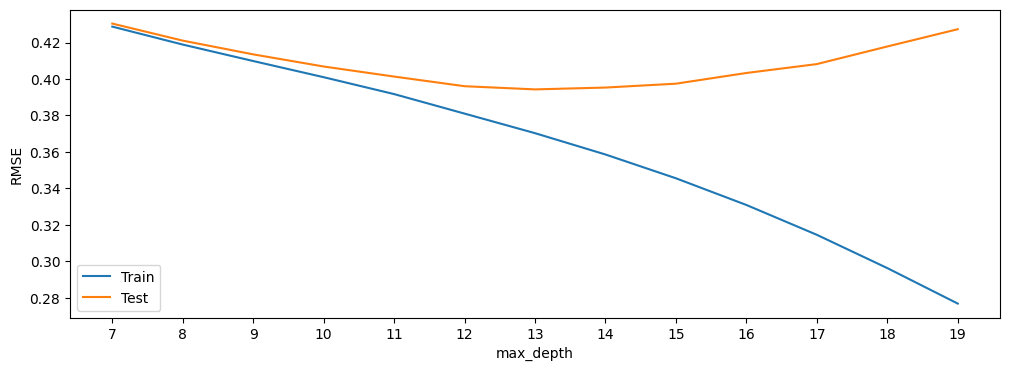

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# создаём список из 13 возможных значений от 7 до 20
max_depths = range(7, 20)

# создаём пустые списки, в которые будем добавлять результаты
train_scores = []
test_scores = []

for depth in max_depths:
    # создаём объект класса DecisionTreeRegressor
    dt_reg = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    # обучаем модель
    dt_reg.fit(X_train, y_train)
    # делаем предсказание для обучающей выборки
    y_train_pred = dt_reg.predict(X_train)
    # делаем предсказание для тестовой выборки
    y_valid_pred = dt_reg.predict(X_test)
    # рассчитываем RMSE для двух выборок и добавляем их в списки
    train_scores.append(MSE(y_train, y_train_pred, squared=False))
    test_scores.append(MSE(y_test, y_valid_pred, squared=False))

# визуализируем изменения RMSE в зависимости от max_depth
fig, ax = plt.subplots(figsize = (12, 4))          # фигура + координатная плоскость
ax.plot(max_depths, train_scores, label = 'Train') # линейный график для обучающей выборки
ax.plot(max_depths, test_scores, label = 'Test') # линейный график для тестовой выборки
ax.set_xlabel('max_depth')                         # название оси абсцисс
ax.set_ylabel('RMSE')                             # название оси ординат
ax.set_xticks(max_depths)                          # метки на оси абсцисс
ax.legend();                                       # отображение легенды

# извлекаем индекс лучшего RMSE на валидационной выборке
best_index = test_scores.index(min(test_scores))
print('Оптимальная глубина дерева решений:', max_depths[best_index])
print('RMSE на обучающей выборке:', round(train_scores[best_index], 2))
print('RMSE на тестовой выборке:', round(test_scores[best_index], 2))

In [ ]:
dtr = DecisionTreeRegressor(max_depth=13, random_state=42)
report_dtr, model_dtr = model_report(dtr, X_train, y_train, X_test, y_test, 'Decision Tree Regressor')

report_dtr

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Decision Tree Regressor,0.773,0.742,0.394,17.488


**Random Forest Regressor // Случайный лес**

https://proglib.io/p/mashinnoe-obuchenie-dlya-nachinayushchih-algoritm-sluchaynogo-lesa-random-forest-2021-08-12
https://habr.com/ru/companies/ruvds/articles/488342/

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
report_rf, model_rf = model_report(rf, X_train, y_train, X_test, y_test, 'Random Forest Regressor')

report_rf

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Random Forest Regressor,0.972,0.797,0.35,1953.956


In [ ]:
import pickle
#filename = 'rf_model.sav'
#pickle.dump(model_rf, open(filename, 'wb'))

#loaded_model = pickle.load(open('/content/rf_model.sav', 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

**Gradient Boosting Regressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
report_gbr, model_gbr = model_report(gbr, X_train, y_train, X_test, y_test, 'Gradient Boosting Regressor')

report_gbr

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Gradient Boosting Regressor,0.745,0.742,0.395,426.449


In [ ]:
import pickle
pickle.dump(model_gbr, open('model_gbr.sav', 'wb'))

**LightGBM**

In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression', metric='rmse')
report_lgb, model_lgb = model_report(model_lgb, X_train, y_train, X_test, y_test, 'LightGBM Regressor')

report_lgb

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,LightGBM Regressor,0.783,0.779,0.366,29.223


In [ ]:
import pickle
pickle.dump(model_lgb, open('model_lgb.sav', 'wb'))

In [ ]:
#concat all models
model_performances = pd.concat([report_lr, report_las, report_eln,
                                report_dtr, report_rf, report_gbr, report_lgb],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

model_performances

,Model,Score (train),Score (test),RMSE,Duration (sec)
0,Linear Regression,0.433,0.424,0.590,2.587
1,Lasso,0.429,0.425,0.589,1.251
2,ElasticNet,0.413,0.413,0.595,2.602
3,Decision Tree Regressor,0.773,0.742,0.394,17.488
4,Random Forest Regressor,0.972,0.797,0.350,1953.956
5,Gradient Boosting Regressor,0.745,0.742,0.395,426.449
6,LightGBM Regressor,0.783,0.779,0.366,29.223


LightGBM невероятно быстр по сравнению с Random Forest и классическим Gradient Boosting, при этом лучше подходит. Это наш явный победитель.

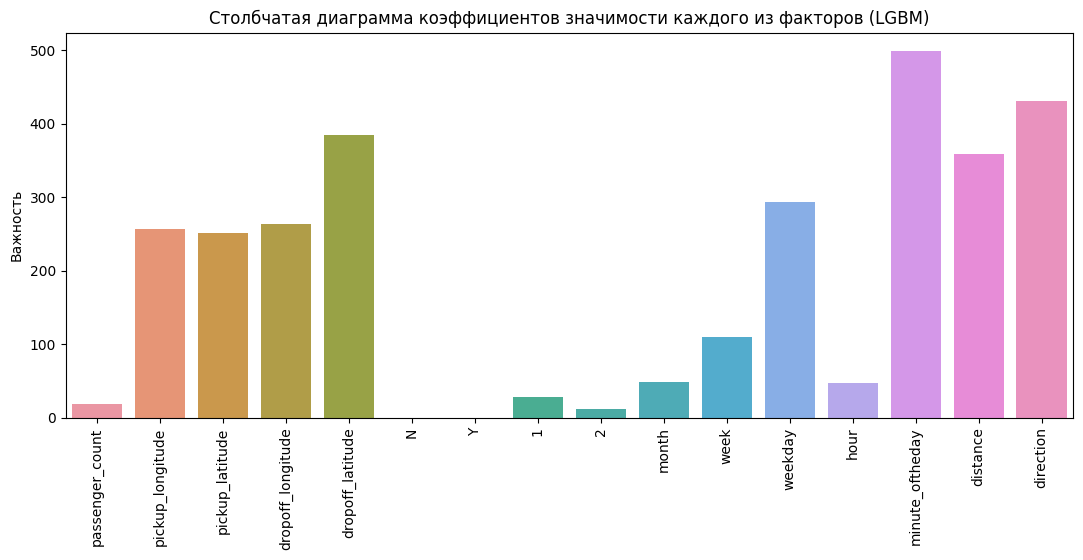

In [ ]:
fig, ax = plt.subplots(figsize = (13, 5)) # фигура + координатная плоскость
features = X_train.columns                # признаки
importances = model_lgb.feature_importances_ # важность признаков

# строим столбчатую диаграмму
sns.barplot(x = features, y = importances, ax = ax)
ax.set_title('Столбчатая диаграмма коэффициентов значимости каждого из факторов (LGBM)') # название графика
ax.set_ylabel('Важность')                  # название оси ординат
ax.xaxis.set_tick_params(rotation = 90)      # поворот меток на оси абсцисс

In [ ]:
# Перекрестная проверка (Cross Validation)
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(model_lgb, X, y, cv=5)
print(cv_score)
print(np.mean(cv_score))

[0.77835965 0.78095047 0.78031906 0.78025173 0.77878507]
0.779733197719256


Наша LightGBM модель стабильна.

## Предсказания

In [ ]:
# Предсказания на тестовых данных (test.zip)
test_df.columns = test_df.columns.astype('str')
test_columns = X.columns
predictions = model_lgb.predict(test_df[test_columns])

In [ ]:
# Результаты
submission = pd.DataFrame({'id': test_df.id, 'trip_duration': np.exp(predictions)})
submission.head()

,id,trip_duration
0,id3004672,860.331017
1,id3505355,718.342451
2,id1217141,458.675784
3,id2150126,1057.994094
4,id1598245,381.988069


# Выводы

В ходе работы мы загрузили и обозревали данные, очистили данные датасета, построили признаки для дальнейшего обучения моделей, обучили несколько разных моделей, сравнили их и сделали предсказания длительности поездки для тестовых данных (test.zip).
В результате сравнения моделей лучшей оказалась модель LightGBM.
В дальнейшем модель можно усовершенствовать, получив самые подходящие гиперпараметры посредством использования инструмента `RandomizedSearchCV`, задав определённое количество кандидатов из пространства параметров с указанным распределением.

**Список используемых источников:**
1. 1.1. Линейные модели : сайт. – URL: https://scikit-learn.ru/1-1-linear-models/ (дата обращения: 14.06.2023)
2. 1.11. Ансамблевые методы : сайт. – URL: https://scikit-learn.ru/1-11-ensemble-methods/ (дата обращения: 14.06.2023)
3. 4 шага к моделированию Machine Learning: практические примеры на Python : сайт. – URL: https://python-school.ru/blog/preprocessing-in-ml-4-steps/ (дата обращения: 14.06.2023)
4. Как использовать Pandas Get Dummies — pd.get_dummies : сайт. – URL: https://www.codecamp.ru/blog/pandas-get-dummies/ (дата обращения: 14.06.2023)
5. Как разработать ансамбль Light Gradient Boosted Machine (LightGBM) : сайт. – URL: https://habr.com/ru/companies/skillfactory/articles/530594/ (дата обращения: 14.06.2023)
6. Машинное обучение для начинающих: алгоритм случайного леса (Random Forest) : сайт. – URL: https://proglib.io/p/mashinnoe-obuchenie-dlya-nachinayushchih-algoritm-sluchaynogo-lesa-random-forest-2021-08-12 (дата обращения: 14.06.2023)
7. Обнаружение выбросов в Machine Learning : сайт. – URL: https://newtechaudit.ru/obnaruzhenie-vybrosov-v-machine-learning/ (дата обращения: 14.06.2023)
8. Очистка данных : сайт. – URL: https://datascience.eu/ru/машинное-обучение/очистка-данных/ (дата обращения: 14.06.2023)
9. Очистка данных: кто их загрязняет и что аналитику с этим делать : сайт. – URL: https://practicum.yandex.ru/blog/chto-takoe-ochistka-dannyh/ (дата обращения: 14.06.2023)
10. Построение и отбор признаков. Часть 1: feature engineering : сайт. – URL: https://proglib.io/p/postroenie-i-otbor-priznakov-chast-1-feature-engineering-2021-09-15 (дата обращения: 14.06.2023)
11. Преобразование данных. Часть 2 | Анализ и обработка данных : сайт. – URL: https://www.dmitrymakarov.ru/data-analysis/transform-08-02/ (дата обращения: 14.06.2023)
12. Тепловая карта корреляции в Seaborn : сайт. – URL: https://www.delftstack.com/ru/howto/seaborn/correlation-heatplot-seaborn-python/ (дата обращения: 14.06.2023)
13. Log normal distribution | Math, Statistics for data science, machine learning : сайт. – URL: https://www.youtube.com/watch?v=xtTX69JZ92w (дата обращения: 14.06.2023)
14. Random Forest, метод главных компонент и оптимизация гиперпараметров: пример решения задачи классификации на Python : сайт. – URL: https://habr.com/ru/companies/ruvds/articles/488342/ (дата обращения: 14.06.2023)
15. What is the reason the log transformation is used with right-skewed distributions? : сайт. – URL: https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution (дата обращения: 14.06.2023)